In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize()
])
train_dataset = datasets.MNIST('./dataset/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./dataset/', train=False,download=True, transform=transform)

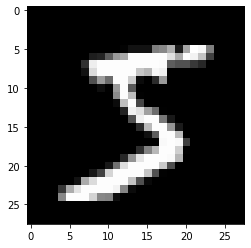

In [5]:
x, y = train_dataset[0]
plt.imshow(x.squeeze(0), cmap='gray')

In [6]:
config = {
    'batch_size': 256,
    'epochs': 100,
    'lr': 1e-4,
    'best_path': './ckpt/best.pth',
    'last_path': './ckpt/last.pth'
}

In [7]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [11]:
x = torch.randn((8, 1, 28, 28))
model = Classifier()
y = model(x)
y.shape

torch.Size([8, 10])

In [17]:
scheduler.state_dict()

{'step_size': 5,
 'gamma': 0.9,
 'base_lrs': [0.0001],
 'last_epoch': 8,
 '_step_count': 9,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [9e-05]}

In [23]:
scheduler.base_lrs

[0.0001]

In [28]:
def trainer(resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = Classifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
    epochs = config['epochs']
    best_acc = 0.0
    start = 0
    if resume:
        checkpoint = torch.load(config['last_path'])
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epochs = checkpoint['epochs']
        start = checkpoint['epoch']
        print(f'[Resume] Resume from Epoch {start}/{epochs} with Learning Rate {scheduler.get_last_lr()}')
    for epoch in range(start, epochs):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        model.train()
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            _, train_pred = torch.max(outputs, dim=1)
            train_acc += (train_pred.detach() == y.detach()).sum().item()
            train_loss += loss.item()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)
                _, test_pred = torch.max(outputs, dim=1)
                test_acc += (test_pred.detach() == y.detach()).sum().item()
                test_loss += loss.item()
        print(f'[{epoch+1:03d}/{epochs:03d}] Train Acc: {train_acc/len(train_dataset):3.5f} Loss: {train_loss/len(train_loader):3.5f} | Test Acc: {test_acc/len(test_dataset):3.5f} loss: {test_loss/len(test_loader):3.5f}')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), config['best_path'])
            torch.save({
                'epoch': epoch+1,
                'epochs': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()
            }, config['last_path'])
            print(f'saving model with acc {best_acc/len(test_dataset):.5f}')

In [ ]:
trainer(resume=True)